In [211]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check cuda version in cmd
# nvcc --version
# Check GPU driver version
# nvidia-smi

In [212]:
# Check PyTorch version
print(torch.__version__)

2.0.1


In [213]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [214]:
# Show Cuda GPU device
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [215]:
torch.cuda.get_arch_list()

['sm_37',
 'sm_50',
 'sm_60',
 'sm_61',
 'sm_70',
 'sm_75',
 'sm_80',
 'sm_86',
 'sm_90',
 'compute_37']

In [216]:
print(torch.backends.cudnn.version())

8700


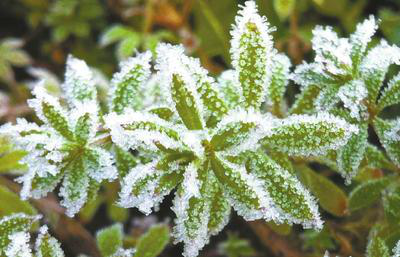

In [217]:
# Open one image from the dataset
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [218]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [219]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [220]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [221]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


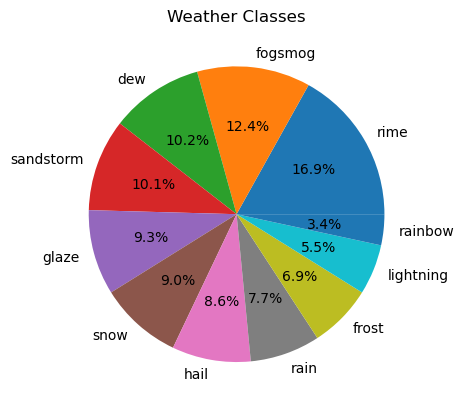

In [222]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

## Split dataset into train, validation and test sets

In [223]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size
train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [224]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.5,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [225]:
# Batch size
batch = 32

# Define Data Loaders
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

# Define variables for sizes of each set
train_data_len = len(train_data)
val_data_len = len(validation_data)
test_data_len = len(test_data)

print("Training images available:", train_data_len)
print("\t")
print("Validation images available:", val_data_len)
print("\t")
print("Testing images available:", test_data_len)

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [226]:
# Display one tensor from train data
train_data[0]

(tensor([[[ 0.2282,  0.2453,  0.2453,  ..., -0.1828, -0.3027, -0.4226],
          [ 0.2282,  0.2282,  0.1939,  ..., -0.1828, -0.2856, -0.4054],
          [ 0.1597,  0.1426,  0.2967,  ..., -0.1486, -0.2513, -0.3712],
          ...,
          [-1.4672, -1.4329, -1.3987,  ..., -1.8439, -1.8610, -1.9295],
          [-1.5357, -1.4672, -1.3815,  ..., -1.9124, -1.9124, -1.9295],
          [-1.1760, -1.1247, -1.0048,  ..., -1.5699, -1.5528, -1.5699]],
 
         [[-0.6001, -0.5651, -0.5126,  ..., -0.7402, -0.8452, -0.9328],
          [-0.5651, -0.5476, -0.5126,  ..., -0.7402, -0.8102, -0.8978],
          [-0.5651, -0.5476, -0.3025,  ..., -0.7052, -0.7752, -0.8803],
          ...,
          [-1.6856, -1.6681, -1.6681,  ..., -1.8957, -1.8782, -1.9307],
          [-1.7381, -1.7206, -1.6681,  ..., -1.9657, -1.9132, -1.9307],
          [-1.3704, -1.3529, -1.3004,  ..., -1.5980, -1.5455, -1.5630]],
 
         [[-1.3513, -1.2990, -1.2293,  ..., -1.2293, -1.2641, -1.3513],
          [-1.2990, -1.2467,

Class Indexes: [ 7  0  2  9  8  8  6  4  2 10 10  4  2  0  8  8]
	
Sample image size: torch.Size([3, 224, 224])
	


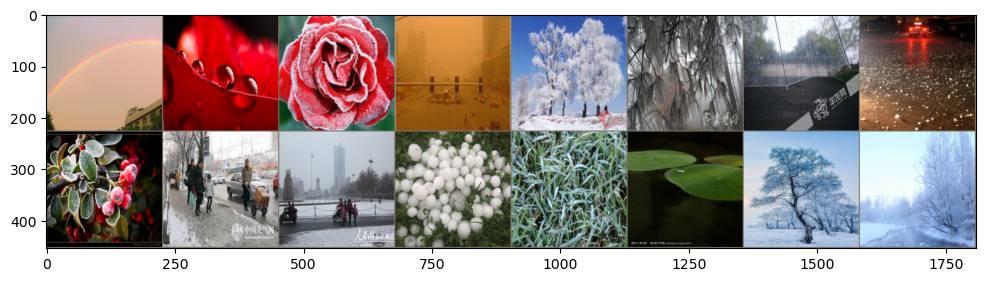

In [227]:
# Grab the first batch of images
for images, labels in train_loader: 
    break
    
# Extract the first 16 images
images_subset = images[:16]
labels_subset = labels[:16]

# Print the labels
print('Class Indexes:', labels_subset.numpy())
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images_subset, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images_subset[0].shape)
print("\t")

## Count number of trainable parameters

In [228]:
def count_parameters(model):
    print("Total sum of weights in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Train and validate model

In [204]:
def train_and_val_model(model, criterion, optimizer, train_loader, val_loader, model_name,
                        train_loss_list, train_corr_list, val_loss_list, val_corr_list):
    start_time = time.time()
    # Number of epochs
    epochs = 50
    
    model_name = model_name

    # Define patience, counter, best validation accuracy and
    # a boolean value that determines if early stop mechanism is to be activated
    patience = 4
    counter = 0
    best_val_acc = 0
    is_early_stop = False


    # For each epoch run the training and validation bathes
    for epoch in range(epochs):
        train_corr = 0
        validation_corr = 0

        # Run the training batches
        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for training
            outputs = model(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            train_corr += (predicted == labels).sum()

            # Update parameters during training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Append losses and correct predictions per epoch
        train_loss_list.append(loss)
        train_corr_list.append(train_corr)

        # Calculate accuracy after each epoch
        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

        # Print each epoch results
        print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3),
              "Train accuracy:", accuracy_train, "%")




        # Run the validation batches
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                # Apply the model for validation
                outputs = model(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                validation_corr += (predicted == labels).sum()

            # Calculate accuracy after each epoch
            accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)



            # Early stopping
            if accuracy_val > best_val_acc:
                best_val_acc = accuracy_val
                counter = 0

                # Save model with best accuracy
                torch.save(model.state_dict(), f"Best{model_name}.pt")
            else:
                counter += 1

            # Check for early stopping after the validation loop
            if counter >= patience:
                is_early_stop = True
                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                      "Validation accuracy:", accuracy_val, "%")
                print("Early stopping triggered. Training stopped.")
                break


        # Append losses and correct predictions per epoch
        val_loss_list.append(loss)
        val_corr_list.append(validation_corr)

        if is_early_stop:
            break
        else:
            # Print each epoch results
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                  "Validation accuracy:", accuracy_val, "%")
            print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
            print("\t")


    print("\n")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Test model

In [178]:
def test_model(model_best, criterion, test_loader, test_corr_list):

    test_corr = 0

    # Run the test batches
    model_best.eval()

    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = model_best(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            test_corr += (predicted == labels).sum()

        # Calculate accuracy
        accuracy = round(test_corr.item() * 100 / test_data_len, 3)

    test_corr_list.append(test_corr)

## Confusion Matrix

In [177]:
def confusion_matrix(model_best):
    
    # Create a loader for the entire test set
    test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
    
    model_best.cpu()

    with torch.no_grad():
        correct = 0
        for images, labels in test_load_all:

            images = images.cpu()
            labels = labels.cpu()

            outputs = model_best(images)
            predicted = torch.max(outputs,1)[1]
            correct += (predicted == labels).sum()

    arr = confusion_matrix(labels.view(-1), predicted.view(-1))
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show();

## Model prediction on single image

In [173]:
def custom_img_prediction(model_best, model_name):
    model_name = model_name
    
    model_best.cpu()
    model_best.eval()
    with torch.no_grad():
        custom_pred = model_best(custom_img_t.view(1,3,224,224)).argmax()

    print(f"{model_name} model prediction:", custom_pred.item())

# Custom CNN

## Define the Convolutional Network (custom CNN)

In [104]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        
        # Convolutional layer
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Batch Normalization layer
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        # Activation layer
        self.relu = nn.ReLU()
        # Pooling Layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(32 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 11)
        # Dropout layer
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.dropout2 = nn.Dropout2d(p=0.2)

    def forward(self, x):
        # 1st Convolutional layer
        x = self.max_pool(self.relu(self.bn1(self.conv1(x))))
        # 2nd Convolutional layer
        x = self.max_pool(self.relu(self.bn2(self.conv2(x))))
        # 3rd Convolutional layer
        x = self.max_pool(self.relu(self.bn3(self.conv3(x))))
        # Flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # 1st Fully Connected layer
        x = self.dropout1(self.relu(self.fc1(x)))
        # 2nd Fully Connected layer
        x = self.dropout2(self.relu(self.fc2(x)))
        # 3rd Fully Connected layer
        x = self.fc3(x)
        # Output layer
        return F.log_softmax(x, dim=1)
    

# (224/2/2/2) = we divided 224 by the number of conv layers by calling pooling layers,
# which leaves us at 28 pixels per side

In [105]:
# Instantiate the model, define loss and optimization functions
CNNmodel = ConvolutionalNetwork()
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11, bias=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
)


In [175]:
count_parameters(CNNmodel)

Total sum of weights in the model:
	
     162
       6
     864
      16
    4608
      32
       6
       6
      16
      16
      32
      32
 6422528
     256
   32768
     128
    1408
      11
________
 6462895


## Hyperparameter tuning

In [186]:
start_time = time.time()

# Define the hyperparameters and their values to search over
learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [32, 64, 128, 256]

best_lr = None
best_batch_size = None
best_accuracy = 0.0

epochs = 50

    
for lr in learning_rates:
    for batch in batch_sizes:
        
        train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
        validation_loader = DataLoader(validation_data, batch_size=batch, shuffle=False)

        CNNmodel = ConvolutionalNetwork()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=lr)

        print("\t")
        print("training CNN model with learning rate:", lr, "and batch size:", batch)
        print("_________________________________________________________________________")
        print("\t")
        
        # Define patience, counter, best validation accuracy and
        # a boolean value that determines if early stop mechanism is to be activated
        patience = 5
        counter = 0
        best_val_acc = 0
        is_early_stop = False

        # For each epoch run the training and validation bathes
        for epoch in range(epochs):
            train_corr = 0
            validation_corr = 0

            # Run the training batches
            for images, labels in train_loader:

                # Apply the model for training
                outputs = CNNmodel(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # Number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                train_corr += (predicted == labels).sum()

                # Update parameters during training
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Calculate accuracy after each epoch
            accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

            # Print each epoch results
            print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
                  "Train accuracy:", accuracy_train, "%")



            
            # Run the validation batches
            CNNmodel.eval()

            with torch.no_grad():
                for images, labels in validation_loader:

                    # Apply the model for validation
                    outputs = CNNmodel(images)
                    # Number of losses
                    loss = criterion(outputs, labels)

                    # Number of correct predictions
                    predicted = torch.max(outputs.data, 1)[1] 
                    validation_corr += (predicted == labels).sum()

                # Calculate accuracy after each epoch
                accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)    



                # Early stopping
                if accuracy_val > best_val_acc:
                    best_val_acc = accuracy_val
                    counter = 0
                else:
                    counter += 1

                # Check for early stopping after the validation loop    
                if counter >= patience:
                    is_early_stop = True
                    print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                          "Validation accuracy:", accuracy_val, "%")            
                    print("Early stopping triggered. Training stopped.")
                    break


            if is_early_stop:
                break
            else:
                # Print each epoch results
                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                      "Validation accuracy:", accuracy_val, "%")
                print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
                print("\t")


        # Check if the current hyperparameters achieved better accuracy
        if best_val_acc > best_accuracy:
            best_accuracy = best_val_acc
            best_lr = lr
            best_batch_size = batch
            print("Current best Hyperparameters: Learning Rate:", best_lr, "Batch Size:", best_batch_size, 
                  "Accuracy:", best_accuracy)
            
                
print("\n")
print("Best Hyperparameters overall: Learning Rate:", best_lr, "Batch Size:", best_batch_size, "Accuracy:", best_accuracy)
print("\t")
print("Duration:", round(time.time() - start_time, 1), "seconds")

	
training CNN model with learning rate: 0.001 and batch size: 32
_________________________________________________________________________
	
Epoch: 1 Train loss: 1.426 Train accuracy: 44.281 %
Epoch: 1 Validation loss: 1.023 Validation accuracy: 60.686 %
best_val_acc: 60.686 counter: 0
	
Epoch: 2 Train loss: 0.708 Train accuracy: 62.961 %
Epoch: 2 Validation loss: 0.844 Validation accuracy: 63.2 %
best_val_acc: 63.2 counter: 0
	
Epoch: 3 Train loss: 0.786 Train accuracy: 71.576 %
Epoch: 3 Validation loss: 0.479 Validation accuracy: 67.429 %
best_val_acc: 67.429 counter: 0
	
Epoch: 4 Train loss: 0.661 Train accuracy: 78.838 %
Epoch: 4 Validation loss: 0.491 Validation accuracy: 69.943 %
best_val_acc: 69.943 counter: 0
	
Epoch: 5 Train loss: 0.295 Train accuracy: 85.475 %
Epoch: 5 Validation loss: 0.28 Validation accuracy: 69.143 %
best_val_acc: 69.943 counter: 1
	
Epoch: 6 Train loss: 0.375 Train accuracy: 91.709 %
Epoch: 6 Validation loss: 0.369 Validation accuracy: 69.943 %
best_val_

Epoch: 11 Train loss: 0.496 Train accuracy: 87.291 %
Epoch: 11 Validation loss: 1.038 Validation accuracy: 70.514 %
best_val_acc: 70.514 counter: 0
	
Epoch: 12 Train loss: 0.212 Train accuracy: 90.014 %
Epoch: 12 Validation loss: 1.237 Validation accuracy: 68.8 %
best_val_acc: 70.514 counter: 1
	
Epoch: 13 Train loss: 0.27 Train accuracy: 93.787 %
Epoch: 13 Validation loss: 1.375 Validation accuracy: 70.514 %
best_val_acc: 70.514 counter: 2
	
Epoch: 14 Train loss: 0.232 Train accuracy: 95.542 %
Epoch: 14 Validation loss: 1.384 Validation accuracy: 69.143 %
best_val_acc: 70.514 counter: 3
	
Epoch: 15 Train loss: 0.152 Train accuracy: 95.905 %
Epoch: 15 Validation loss: 1.496 Validation accuracy: 69.486 %
best_val_acc: 70.514 counter: 4
	
Epoch: 16 Train loss: 0.085 Train accuracy: 97.862 %
Epoch: 16 Validation loss: 1.623 Validation accuracy: 71.429 %
best_val_acc: 71.429 counter: 0
	
Epoch: 17 Train loss: 0.1 Train accuracy: 97.801 %
Epoch: 17 Validation loss: 1.66 Validation accuracy:

Epoch: 11 Validation loss: 1.043 Validation accuracy: 63.2 %
best_val_acc: 64.457 counter: 2
	
Epoch: 12 Train loss: 0.954 Train accuracy: 77.224 %
Epoch: 12 Validation loss: 1.065 Validation accuracy: 65.829 %
best_val_acc: 65.829 counter: 0
	
Epoch: 13 Train loss: 0.645 Train accuracy: 80.169 %
Epoch: 13 Validation loss: 1.004 Validation accuracy: 65.029 %
best_val_acc: 65.829 counter: 1
	
Epoch: 14 Train loss: 0.551 Train accuracy: 81.521 %
Epoch: 14 Validation loss: 1.196 Validation accuracy: 63.771 %
best_val_acc: 65.829 counter: 2
	
Epoch: 15 Train loss: 0.31 Train accuracy: 84.85 %
Epoch: 15 Validation loss: 1.296 Validation accuracy: 67.657 %
best_val_acc: 67.657 counter: 0
	
Epoch: 16 Train loss: 0.365 Train accuracy: 86.907 %
Epoch: 16 Validation loss: 1.292 Validation accuracy: 66.743 %
best_val_acc: 67.657 counter: 1
	
Epoch: 17 Train loss: 0.488 Train accuracy: 88.037 %
Epoch: 17 Validation loss: 1.347 Validation accuracy: 64.8 %
best_val_acc: 67.657 counter: 2
	
Epoch: 18

Epoch: 4 Train loss: 0.958 Train accuracy: 54.973 %
Epoch: 4 Validation loss: 1.164 Validation accuracy: 56.8 %
best_val_acc: 56.8 counter: 0
	
Epoch: 5 Train loss: 1.266 Train accuracy: 57.837 %
Epoch: 5 Validation loss: 1.256 Validation accuracy: 58.4 %
best_val_acc: 58.4 counter: 0
	
Epoch: 6 Train loss: 0.797 Train accuracy: 62.78 %
Epoch: 6 Validation loss: 1.248 Validation accuracy: 54.743 %
best_val_acc: 58.4 counter: 1
	
Epoch: 7 Train loss: 0.743 Train accuracy: 66.451 %
Epoch: 7 Validation loss: 1.04 Validation accuracy: 60.114 %
best_val_acc: 60.114 counter: 0
	
Epoch: 8 Train loss: 0.886 Train accuracy: 69.901 %
Epoch: 8 Validation loss: 0.875 Validation accuracy: 58.971 %
best_val_acc: 60.114 counter: 1
	
Epoch: 9 Train loss: 0.58 Train accuracy: 72.423 %
Epoch: 9 Validation loss: 1.017 Validation accuracy: 59.429 %
best_val_acc: 60.114 counter: 2
	
Epoch: 10 Train loss: 0.717 Train accuracy: 75.025 %
Epoch: 10 Validation loss: 1.369 Validation accuracy: 59.314 %
best_val_

Epoch: 20 Train loss: 0.747 Train accuracy: 77.143 %
Epoch: 20 Validation loss: 1.392 Validation accuracy: 62.057 %
best_val_acc: 62.286 counter: 3
	
Epoch: 21 Train loss: 0.54 Train accuracy: 82.126 %
Epoch: 21 Validation loss: 1.613 Validation accuracy: 61.943 %
best_val_acc: 62.286 counter: 4
	
Epoch: 22 Train loss: 0.694 Train accuracy: 84.547 %
Epoch: 22 Validation loss: 1.636 Validation accuracy: 60.0 %
Early stopping triggered. Training stopped.


Best Hyperparameters overall: Learning Rate: 0.001 Batch Size: 32 Accuracy: 72.571
	
Duration: 21545.5 seconds


## Set the best hyperparameters

In [187]:
train_loader = DataLoader(train_data, batch_size=best_batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=best_batch_size, shuffle=False)

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=best_lr)

## Train the model (custom CNN)

In [188]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 5
counter = 0
best_val_acc = 0
is_early_stop = False

# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for images, labels in train_loader:

        # Apply the model for training
        outputs = CNNmodel(images)
        # Number of losses
        loss = criterion(outputs, labels)
 
        # Number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters during training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Append losses and correct predictions per epoch 
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")



    
    # Run the validation batches
    CNNmodel.eval()
    
    with torch.no_grad():
        for images, labels in validation_loader:
            
            # Apply the model for validation
            outputs = CNNmodel(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # Number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()
        
        # Calculate accuracy after each epoch
        accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)    
            
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(CNNmodel.state_dict(), 'BestCustomCNNModel.pt')
            
        else:
            counter += 1
            
        # Check for early stopping after the validation loop    
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch             
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    

print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 1.227 Train accuracy: 45.935 %
Epoch: 1 Validation loss: 0.826 Validation accuracy: 60.457 %
best_val_acc: 60.457 counter: 0
	
Epoch: 2 Train loss: 1.113 Train accuracy: 65.221 %
Epoch: 2 Validation loss: 0.73 Validation accuracy: 67.2 %
best_val_acc: 67.2 counter: 0
	
Epoch: 3 Train loss: 0.884 Train accuracy: 70.587 %
Epoch: 3 Validation loss: 0.658 Validation accuracy: 65.714 %
best_val_acc: 67.2 counter: 1
	
Epoch: 4 Train loss: 0.635 Train accuracy: 75.63 %
Epoch: 4 Validation loss: 0.775 Validation accuracy: 68.686 %
best_val_acc: 68.686 counter: 0
	
Epoch: 5 Train loss: 0.471 Train accuracy: 82.187 %
Epoch: 5 Validation loss: 0.691 Validation accuracy: 69.257 %
best_val_acc: 69.257 counter: 0
	
Epoch: 6 Train loss: 0.525 Train accuracy: 89.106 %
Epoch: 6 Validation loss: 0.254 Validation accuracy: 69.829 %
best_val_acc: 69.829 counter: 0
	
Epoch: 7 Train loss: 0.139 Train accuracy: 91.608 %
Epoch: 7 Validation loss: 0.689 Validation accuracy: 71.314 %
best_v

## Evaluate model performance (custom CNN)

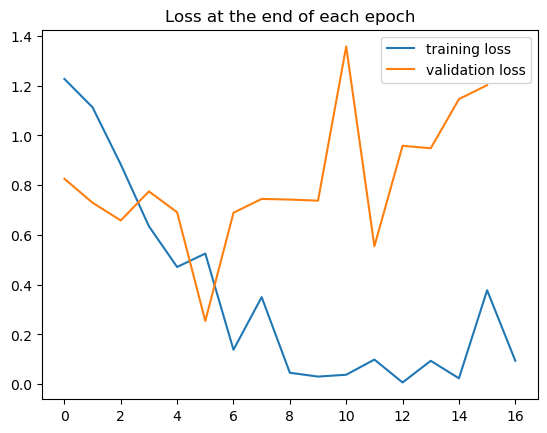

In [189]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

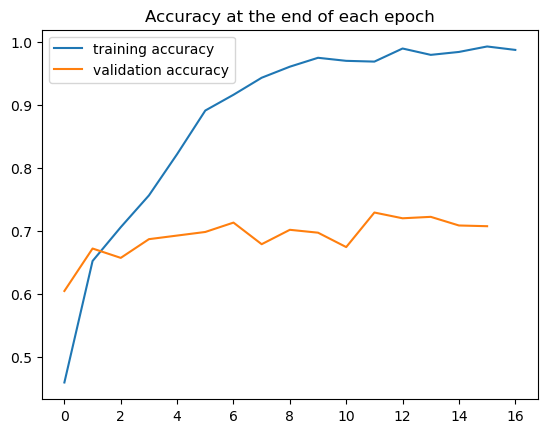

In [190]:
# Plot accuracy
plt.plot([t / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [191]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(2277), tensor(3233), tensor(3499), tensor(3749), tensor(4074), tensor(4417), tensor(4541), tensor(4675), tensor(4762), tensor(4832), tensor(4808), tensor(4802), tensor(4905), tensor(4855), tensor(4878), tensor(4921), tensor(4894)]
	
Validation Correct: [tensor(529), tensor(588), tensor(575), tensor(601), tensor(606), tensor(611), tensor(624), tensor(594), tensor(614), tensor(610), tensor(590), tensor(638), tensor(630), tensor(632), tensor(620), tensor(619)]


## Load saved model (custom CNN)

In [192]:
CNNmodel_best = ConvolutionalNetwork()
CNNmodel_best.load_state_dict(torch.load('BestCustomCNNModel.pt'))

<All keys matched successfully>

## Test the model (custom CNN)

In [193]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
CNNmodel_best.eval()

with torch.no_grad():
    for images, labels in test_loader:

        # Apply the model for validation
        outputs = CNNmodel_best(images)
        # Number of losses
        loss = criterion(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
        
    # Calculate accuracy    
    accuracy = round(test_corr.item() * 100 / test_data_len, 3)

test_correct.append(test_corr)

In [194]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(723)]
Test Accuracy: 70.194 %


## Confusion Matrix (custom CNN)

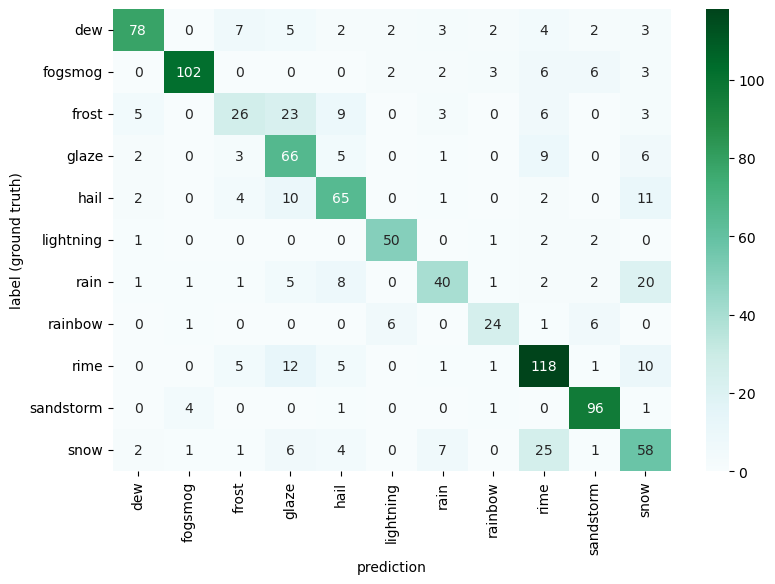

In [195]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = CNNmodel_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# AlexNet

## Loading AlexNet model

In [43]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [44]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [45]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
AlexNetmodel.classifier[6] = nn.Linear(4096, 11)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [46]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

Total sum of weights in the model:
	
   45056
      11
________
   45067


In [47]:
# Define loss and optimization functions
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = torch.optim.AdamW(AlexNetmodel.classifier.parameters(), lr=0.005)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False)

## Train model (AlexNet)

In [48]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 4
counter = 0
best_val_acc = 0
is_early_stop = False


# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for images, labels in train_loader:

        # Apply the model for training
        outputs = AlexNetmodel(images)
        # Number of losses
        loss = criterion_AlexNet(outputs, labels)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters during training
        optimizer_AlexNet.zero_grad()
        loss.backward()
        optimizer_AlexNet.step()

    # Append losses and correct predictions per epoch
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")


    
    
    # Run the validation batches
    AlexNetmodel.eval()
    
    with torch.no_grad():
        for images, labels in validation_loader:
            
            # Apply the model for validation
            outputs = AlexNetmodel(images)
            # Number of losses
            loss = criterion_AlexNet(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()

        # Calculate accuracy after each epoch   
        accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)
        
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(AlexNetmodel.state_dict(), 'BestAlexNetmodel.pt')
        else:
            counter += 1

        # Check for early stopping after the validation loop      
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch       
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
        
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 0.608 Train accuracy: 76.8 %
Epoch: 1 Validation loss: 0.619 Validation accuracy: 84.0 %
best_val_acc: 84.0 counter: 0
	
Epoch: 2 Train loss: 0.316 Train accuracy: 90.619 %
Epoch: 2 Validation loss: 0.516 Validation accuracy: 85.371 %
best_val_acc: 85.371 counter: 0
	
Epoch: 3 Train loss: 0.18 Train accuracy: 95.199 %
Epoch: 3 Validation loss: 0.504 Validation accuracy: 84.8 %
best_val_acc: 85.371 counter: 1
	
Epoch: 4 Train loss: 0.088 Train accuracy: 97.579 %
Epoch: 4 Validation loss: 0.616 Validation accuracy: 86.4 %
best_val_acc: 86.4 counter: 0
	
Epoch: 5 Train loss: 0.019 Train accuracy: 98.931 %
Epoch: 5 Validation loss: 0.691 Validation accuracy: 86.743 %
best_val_acc: 86.743 counter: 0
	
Epoch: 6 Train loss: 0.023 Train accuracy: 99.395 %
Epoch: 6 Validation loss: 0.441 Validation accuracy: 86.857 %
best_val_acc: 86.857 counter: 0
	
Epoch: 7 Train loss: 0.012 Train accuracy: 99.657 %
Epoch: 7 Validation loss: 0.541 Validation accuracy: 87.2 %
best_val_acc:

## Evaluate model performance (AlexNet)

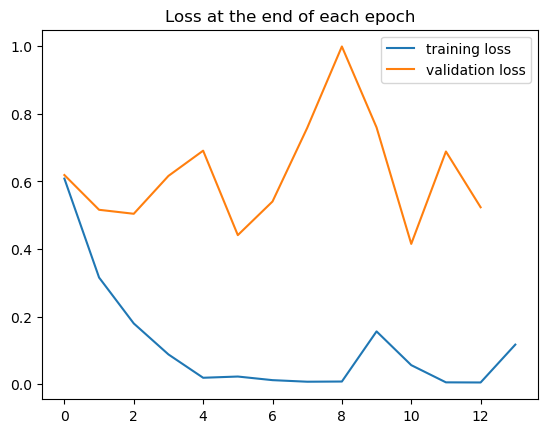

In [49]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

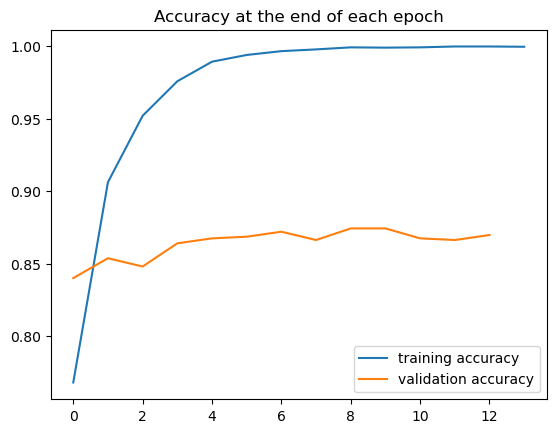

In [50]:
# Plot accuracy
plt.plot([t / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [51]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(3807), tensor(4492), tensor(4719), tensor(4837), tensor(4904), tensor(4927), tensor(4940), tensor(4946), tensor(4953), tensor(4952), tensor(4953), tensor(4956), tensor(4956), tensor(4955)]
	
Validation Correct: [tensor(735), tensor(747), tensor(742), tensor(756), tensor(759), tensor(760), tensor(763), tensor(758), tensor(765), tensor(765), tensor(759), tensor(758), tensor(761)]


## Load saved model (AlexNet)

In [52]:
AlexNetmodel_best = models.alexnet(pretrained=True)
AlexNetmodel_best.classifier[6] = nn.Linear(4096, 11)
AlexNetmodel_best.load_state_dict(torch.load('BestAlexNetmodel.pt'))

<All keys matched successfully>

## Test the model (AlexNet)

In [53]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
AlexNetmodel_best.eval()

with torch.no_grad():
    for images, labels in test_loader:

        # Apply the model for validation
        outputs = AlexNetmodel_best(images)
        # Number of losses
        loss = criterion_AlexNet(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
    
    # Calculate accuracy
    accuracy = round(test_corr.item() * 100 / test_data_len, 3)

test_correct.append(test_corr)

In [54]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(900)]
Test Accuracy: 87.379 %


## Confusion Matrix (AlexNet)

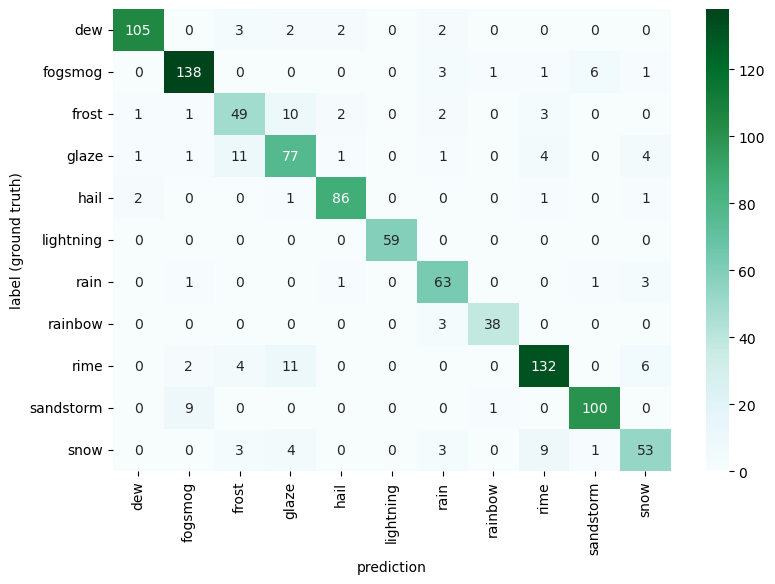

In [55]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = AlexNetmodel_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# VGG19 with batch normalization

In [22]:
VGG19 = models.vgg19_bn(pretrained=True, progress=True)

In [24]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in VGG19.parameters():
    param.requires_grad = False

In [25]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
VGG19.classifier[6] = nn.Linear(4096, 11)
VGG19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [26]:
count_parameters(VGG19)

Total sum of weights in the model:
	
   45056
      11
________
   45067


In [30]:
# Define loss and optimization functions
criterion_VGG19 = nn.CrossEntropyLoss()
optimizer_VGG19 = torch.optim.AdamW(VGG19.classifier.parameters(), lr=0.001)

In [22]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

## Train model (VGG19)

In [23]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 4
counter = 0
best_val_acc = 0
is_early_stop = False


# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for images, labels in train_loader:

        # Apply the model for training
        outputs = VGG19(images)
        # Number of losses
        loss = criterion_VGG19(outputs, labels)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters during training
        optimizer_VGG19.zero_grad()
        loss.backward()
        optimizer_VGG19.step()

    # Append losses and correct predictions per epoch
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")


    
    
    # Run the validation batches
    VGG19.eval()
    
    with torch.no_grad():
        for images, labels in validation_loader:
            
            # Apply the model for validation
            outputs = VGG19(images)
            # Number of losses
            loss = criterion_VGG19(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()

        # Calculate accuracy after each epoch   
        accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)
        
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(VGG19.state_dict(), 'BestVGG19.pt')
        else:
            counter += 1

        # Check for early stopping after the validation loop      
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch       
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
        
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 0.615 Train accuracy: 74.44 %
Epoch: 1 Validation loss: 0.492 Validation accuracy: 84.914 %
best_val_acc: 84.914 counter: 0
	
Epoch: 2 Train loss: 0.442 Train accuracy: 86.443 %
Epoch: 2 Validation loss: 0.491 Validation accuracy: 85.714 %
best_val_acc: 85.714 counter: 0
	
Epoch: 3 Train loss: 0.134 Train accuracy: 88.541 %
Epoch: 3 Validation loss: 0.458 Validation accuracy: 85.829 %
best_val_acc: 85.829 counter: 0
	
Epoch: 4 Train loss: 0.259 Train accuracy: 91.063 %
Epoch: 4 Validation loss: 0.536 Validation accuracy: 85.714 %
best_val_acc: 85.829 counter: 1
	
Epoch: 5 Train loss: 0.12 Train accuracy: 92.455 %
Epoch: 5 Validation loss: 0.465 Validation accuracy: 86.514 %
best_val_acc: 86.514 counter: 0
	
Epoch: 6 Train loss: 0.278 Train accuracy: 94.19 %
Epoch: 6 Validation loss: 0.542 Validation accuracy: 87.886 %
best_val_acc: 87.886 counter: 0
	
Epoch: 7 Train loss: 0.263 Train accuracy: 95.219 %
Epoch: 7 Validation loss: 0.578 Validation accuracy: 86.743 %
b

## Evaluate model performance (VGG19)

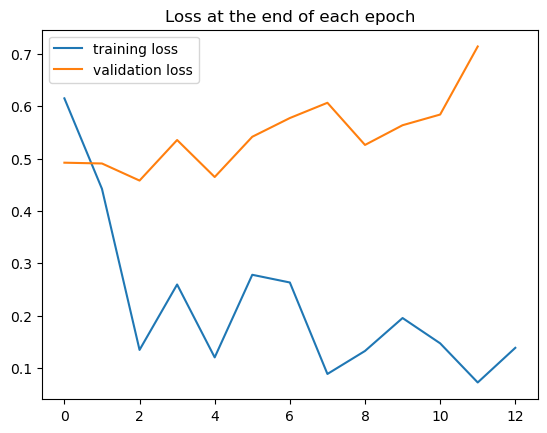

In [24]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

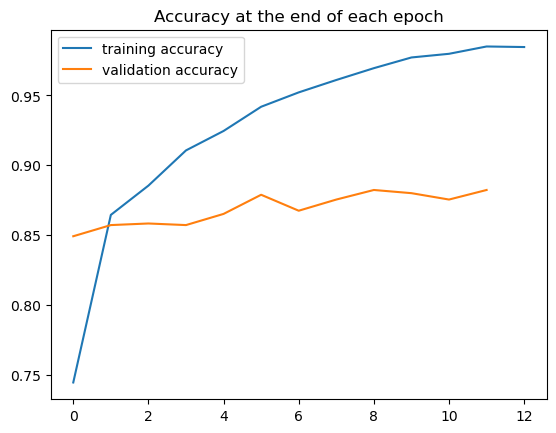

In [25]:
# Plot accuracy
plt.plot([t / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [26]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(3690), tensor(4285), tensor(4389), tensor(4514), tensor(4583), tensor(4669), tensor(4720), tensor(4764), tensor(4806), tensor(4844), tensor(4857), tensor(4883), tensor(4881)]
	
Validation Correct: [tensor(743), tensor(750), tensor(751), tensor(750), tensor(757), tensor(769), tensor(759), tensor(766), tensor(772), tensor(770), tensor(766), tensor(772)]


## Load saved model (VGG19)

In [27]:
VGG19_best = models.vgg19_bn(pretrained=True)
VGG19_best.classifier[6] = nn.Linear(4096, 11)
VGG19_best.load_state_dict(torch.load('BestVGG19.pt'))

<All keys matched successfully>

## Test the model (VGG19)

In [28]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
VGG19_best.eval()

with torch.no_grad():
    for images, labels in test_loader:

        # Apply the model for validation
        outputs = VGG19_best(images)
        # Number of losses
        loss = criterion_VGG19(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
    
    # Calculate accuracy
    accuracy = round(test_corr.item() * 100 / test_data_len, 3)

test_correct.append(test_corr)

In [29]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(908)]
Test Accuracy: 88.155 %


## Confusion matrix (VGG19) 

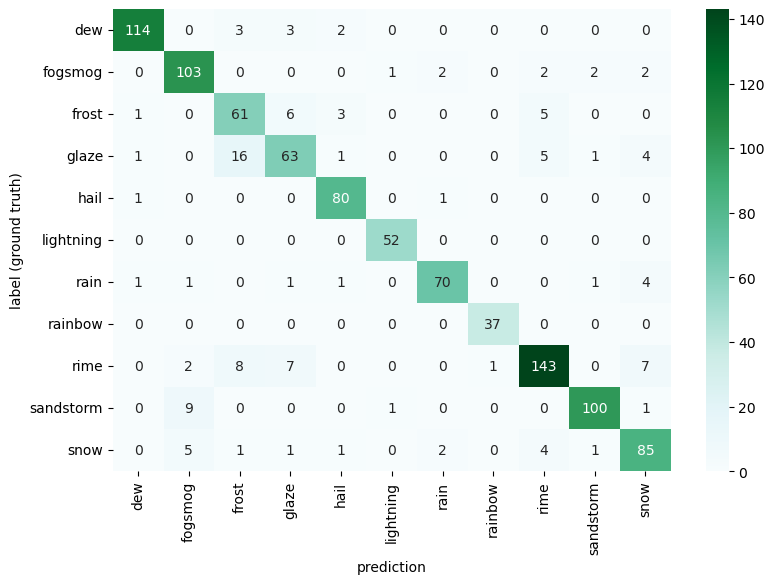

In [30]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = VGG19_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# MobileNet

In [142]:
MobileNet = models.mobilenet_v2(pretrained=True)
MobileNet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [165]:
MobileNet.to(device)
next(MobileNet.parameters()).is_cuda

True

In [152]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in MobileNet.parameters():
    param.requires_grad = False

In [153]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
MobileNet.classifier[1] = nn.Linear(1280, 11)
MobileNet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [154]:
count_parameters(MobileNet)

Total sum of weights in the model:
	
   14080
      11
________
   14091


In [166]:
# Define loss and optimization functions
criterion_MobileNet = nn.CrossEntropyLoss()
optimizer_MobileNet = torch.optim.AdamW(MobileNet.classifier.parameters(), lr=0.001)

In [167]:
# Move optimizer state to the GPU
for state in optimizer_MobileNet.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

## Train model (MobileNetv2)

In [79]:
start_time = time.time()
# Number of epochs
epochs = 50

# Create lists to append losses and correct predictions per epoch
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

# Define patience, counter, best validation accuracy and
# a boolean value that determines if early stop mechanism is to be activated
patience = 4
counter = 0
best_val_acc = 0
is_early_stop = False


# For each epoch run the training and validation bathes
for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0

    # Run the training batches
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        # Apply the model for training
        outputs = MobileNet(images)
        # Number of losses
        loss = criterion_MobileNet(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()

        # Update parameters during training
        optimizer_MobileNet.zero_grad()
        loss.backward()
        optimizer_MobileNet.step()

    # Append losses and correct predictions per epoch
    train_losses.append(loss)
    train_correct.append(train_corr)

    # Calculate accuracy after each epoch
    accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3),
          "Train accuracy:", accuracy_train, "%")




    # Run the validation batches
    MobileNet.eval()

    with torch.no_grad():
        for images, labels in validation_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = MobileNet(images)
            # Number of losses
            loss = criterion_MobileNet(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            validation_corr += (predicted == labels).sum()

        # Calculate accuracy after each epoch
        accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)



        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0

            # Save model with best accuracy
            torch.save(MobileNet.state_dict(), 'BestMobileNet.pt')
        else:
            counter += 1

        # Check for early stopping after the validation loop
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                  "Validation accuracy:", accuracy_val, "%")
            print("Early stopping triggered. Training stopped.")
            break


    # Append losses and correct predictions per epoch
    validation_losses.append(loss)
    validation_correct.append(validation_corr)

    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")


print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 0.728 Train accuracy: 80.855 %
Epoch: 1 Validation loss: 1.582 Validation accuracy: 85.714 %
best_val_acc: 85.714 counter: 0
	
Epoch: 2 Train loss: 0.81 Train accuracy: 86.625 %
Epoch: 2 Validation loss: 1.46 Validation accuracy: 87.429 %
best_val_acc: 87.429 counter: 0
	
Epoch: 3 Train loss: 0.281 Train accuracy: 88.743 %
Epoch: 3 Validation loss: 1.521 Validation accuracy: 88.914 %
best_val_acc: 88.914 counter: 0
	
Epoch: 4 Train loss: 0.666 Train accuracy: 90.095 %
Epoch: 4 Validation loss: 1.745 Validation accuracy: 89.486 %
best_val_acc: 89.486 counter: 0
	
Epoch: 5 Train loss: 0.2 Train accuracy: 91.103 %
Epoch: 5 Validation loss: 1.629 Validation accuracy: 88.343 %
best_val_acc: 89.486 counter: 1
	
Epoch: 6 Train loss: 0.146 Train accuracy: 91.85 %
Epoch: 6 Validation loss: 1.793 Validation accuracy: 90.057 %
best_val_acc: 90.057 counter: 0
	
Epoch: 7 Train loss: 0.28 Train accuracy: 92.516 %
Epoch: 7 Validation loss: 1.465 Validation accuracy: 89.257 %
best

## Evaluate model performance (MobileNet)

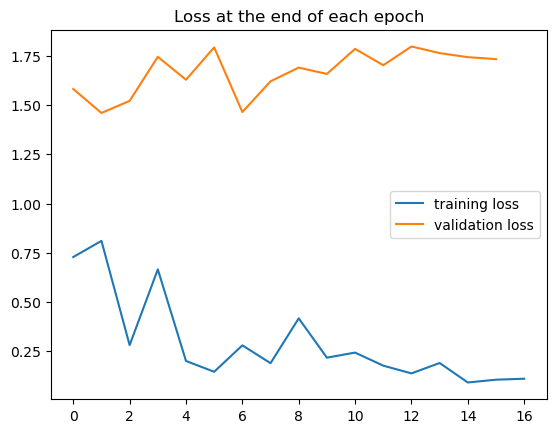

In [80]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

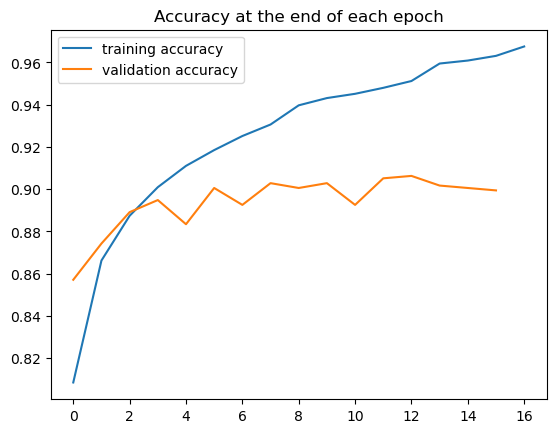

In [81]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [82]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(4008, device='cuda:0'), tensor(4294, device='cuda:0'), tensor(4399, device='cuda:0'), tensor(4466, device='cuda:0'), tensor(4516, device='cuda:0'), tensor(4553, device='cuda:0'), tensor(4586, device='cuda:0'), tensor(4613, device='cuda:0'), tensor(4658, device='cuda:0'), tensor(4675, device='cuda:0'), tensor(4685, device='cuda:0'), tensor(4699, device='cuda:0'), tensor(4715, device='cuda:0'), tensor(4756, device='cuda:0'), tensor(4763, device='cuda:0'), tensor(4774, device='cuda:0'), tensor(4796, device='cuda:0')]
	
Validation Correct: [tensor(750, device='cuda:0'), tensor(765, device='cuda:0'), tensor(778, device='cuda:0'), tensor(783, device='cuda:0'), tensor(773, device='cuda:0'), tensor(788, device='cuda:0'), tensor(781, device='cuda:0'), tensor(790, device='cuda:0'), tensor(788, device='cuda:0'), tensor(790, device='cuda:0'), tensor(781, device='cuda:0'), tensor(792, device='cuda:0'), tensor(793, device='cuda:0'), tensor(789, device='cuda:0'), tensor(788, de

## Load saved model (MobileNet)

In [83]:
MobileNet_best = models.mobilenet_v2(pretrained=True)
MobileNet_best.classifier[1] = nn.Linear(1280, 11)
MobileNet_best.load_state_dict(torch.load('BestMobileNet.pt'))

<All keys matched successfully>

In [84]:
MobileNet_best.to(device)
next(MobileNet_best.parameters()).is_cuda

True

## Test the model (MobileNet)

In [85]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
MobileNet_best.eval()

with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        # Apply the model for validation
        outputs = MobileNet_best(images)
        # Number of losses
        loss = criterion_MobileNet(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        test_corr += (predicted == labels).sum()

    # Calculate accuracy
    accuracy = round(test_corr.item() * 100 / test_data_len, 3)

test_correct.append(test_corr)

In [86]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(905, device='cuda:0')]
Test Accuracy: 87.864 %


## Confusion matrix (MobileNet)

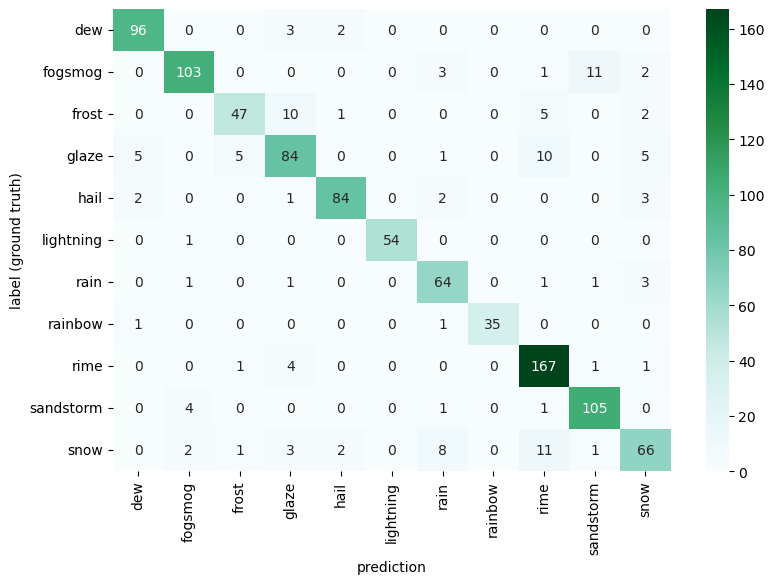

In [87]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
MobileNet_best.cpu()

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:

        images = images.cpu()
        labels = labels.cpu()

        outputs = MobileNet_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# ShuffleNet

In [229]:
ShuffleNet = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [248]:
ShuffleNet.to(device)
next(ShuffleNet.parameters()).is_cuda

True

In [239]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in ShuffleNet.parameters():
    param.requires_grad = False

In [240]:
# Cassifier was modified so that we have 11 output features in the last linear layer instead of 1000 and
ShuffleNet.fc = nn.Linear(2048, 11)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [241]:
count_parameters(ShuffleNet)

Total sum of weights in the model:
	
   22528
      11
________
   22539


In [242]:
# Define loss and optimization functions
criterion_ShuffleNet = nn.CrossEntropyLoss()
optimizer_ShuffleNet = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=0.001)

In [249]:
# Move optimizer state to the GPU
for state in optimizer_ShuffleNet.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [250]:
train_loss_ShuffleNet = []
train_corr_ShuffleNet = []
val_loss_ShuffleNet = []
val_corr_ShuffleNet = []

train_and_val_model(ShuffleNet, criterion_ShuffleNet, optimizer_ShuffleNet, train_loader, validation_loader, "ShuffleNet",
                   train_loss_ShuffleNet, train_corr_ShuffleNet, val_loss_ShuffleNet, val_corr_ShuffleNet)

Epoch: 1 Train loss: 0.608 Train accuracy: 75.388 %
Epoch: 1 Validation loss: 0.532 Validation accuracy: 86.057 %
best_val_acc: 86.057 counter: 0
	
Epoch: 2 Train loss: 1.549 Train accuracy: 87.19 %
Epoch: 2 Validation loss: 0.339 Validation accuracy: 86.4 %
best_val_acc: 86.4 counter: 0
	
Epoch: 3 Train loss: 0.168 Train accuracy: 90.357 %
Epoch: 3 Validation loss: 0.431 Validation accuracy: 87.771 %
best_val_acc: 87.771 counter: 0
	
Epoch: 4 Train loss: 0.304 Train accuracy: 92.374 %
Epoch: 4 Validation loss: 0.372 Validation accuracy: 88.343 %
best_val_acc: 88.343 counter: 0
	
Epoch: 5 Train loss: 0.149 Train accuracy: 93.323 %
Epoch: 5 Validation loss: 0.358 Validation accuracy: 88.8 %
best_val_acc: 88.8 counter: 0
	
Epoch: 6 Train loss: 0.161 Train accuracy: 94.573 %
Epoch: 6 Validation loss: 0.388 Validation accuracy: 88.8 %
best_val_acc: 88.8 counter: 1
	
Epoch: 7 Train loss: 0.115 Train accuracy: 95.138 %
Epoch: 7 Validation loss: 0.412 Validation accuracy: 87.886 %
best_val_ac

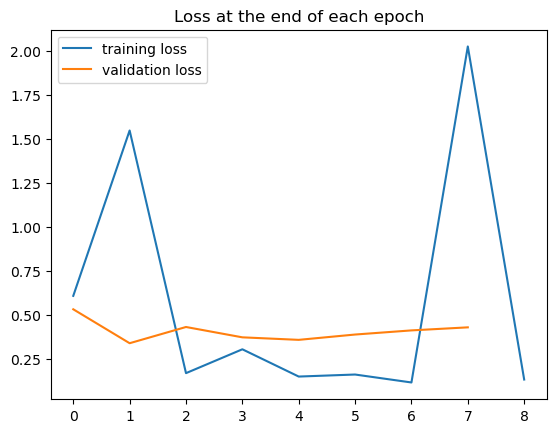

In [251]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_loss_ShuffleNet], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_ShuffleNet], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

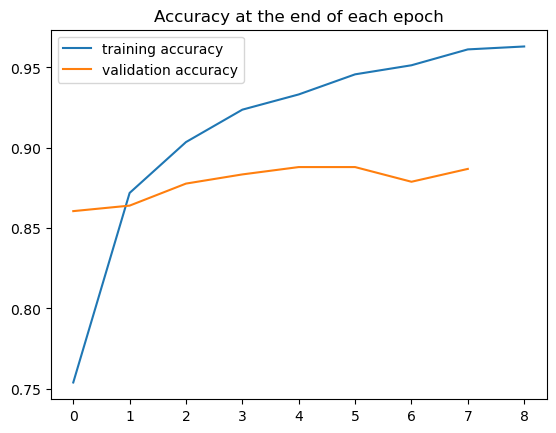

In [252]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_corr_ShuffleNet], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_ShuffleNet], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	


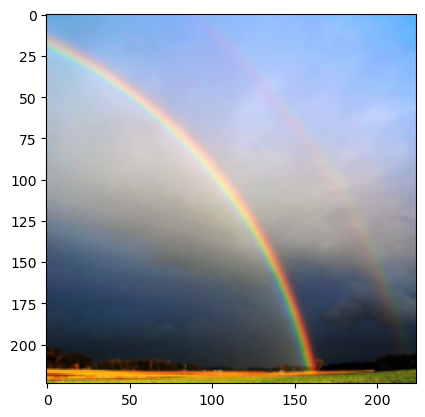

In [97]:
# Open a custom image
custom_img = Image.open('custom_images/1.jpg')

# Define transformations for the image
transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

# Inverse normalize the image
custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

print("Classes:", classes)
print("\t")

In [197]:
# CNN Model Prediction:
CNNmodel_best.eval()
with torch.no_grad():
    custom_pred = CNNmodel_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("Custom CNN model prediction:", custom_pred.item())

Custom CNN model prediction: 7


In [198]:
# AlexNet Model Prediction:
AlexNetmodel_best.eval()
with torch.no_grad():
    custom_pred = AlexNetmodel_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("AlexNet model prediction:", custom_pred.item())

AlexNet model prediction: 7


In [32]:
# VGG19 Model Prediction:
VGG19_best.eval()
with torch.no_grad():
    custom_pred = VGG19_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("VGG19 model prediction:", custom_pred.item())

VGG19 model prediction: 7


In [98]:
# MobileNet Model Prediction:
MobileNet_best.cpu()
MobileNet_best.eval()
with torch.no_grad():
    custom_pred = MobileNet_best(custom_img_t.view(1,3,224,224)).argmax()

print("MobileNet model prediction:", custom_pred.item())

MobileNet model prediction: 7
